In [ ]:
import stVGP
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import os
from matplotlib.image import imread
import torch

import warnings
warnings.filterwarnings("ignore")

d:\anaconda\envs\xw_cuda117\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
count = pd.read_csv("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Raw_data/filtered_matrix.tsv",
                    sep="\t", index_col=0).T

meta = pd.read_csv("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Raw_data/meta_data.tsv",
                   sep="\t", index_col=0)

genes_new = pd.read_csv("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Raw_data/genes_new.txt")

count.columns = list(genes_new.x.values)
count = count.loc[:, count.columns.notna()]

adata_st_list_raw = []
for i in range(1, 10):
    count_i = count[[loc.split("x")[0]==str(i+4) for loc in count.index]]
    count_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in count_i.index]
    meta_i = meta[[loc.split("x")[0]==str(i+4) for loc in meta.index]]
    meta_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in meta_i.index]

    loc_i = pd.read_csv("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Raw_data/dgnysc3zn5-1/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/spot_data-all-ST_Sample_6.5PCW_%d.tsv" % (i, i),
                       sep="\t")

    loc_i.index = [(str(loc_i.x.values[k]) + 'x' + str(loc_i.y.values[k])) for k in range(loc_i.shape[0])]
    loc_i = loc_i.loc[meta_i.index]

    img_i = imread('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Raw_data/dgnysc3zn5-1/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/ST_Sample_6.5PCW_%d_HE_small.jpg' % (i, i))

    adata_st_i = ad.AnnData(X = count_i.values)

    adata_st_i.obs = meta_i
    adata_st_i.obs['selected'] = loc_i['selected'].values
    adata_st_i.var.index = count_i.columns

    library_id = '0'
    adata_st_i.uns["spatial"] = dict()
    adata_st_i.uns["spatial"]['0'] = dict()
    adata_st_i.uns["spatial"]['0']['images'] = dict()
    adata_st_i.uns["spatial"]['0']['images']['hires'] = img_i
    adata_st_i.uns["spatial"]['0']['scalefactors'] = {'spot_diameter_fullres': 100,
                                                      'tissue_hires_scalef': 1.0,
                                                      'fiducial_diameter_fullres': 100,
                                                      'tissue_lowres_scalef': 1.0}

    adata_st_i.obsm['spatial'] = np.concatenate((loc_i['pixel_x'].values.reshape(-1, 1),
                                                 loc_i['pixel_y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obsm['loc_use'] = np.concatenate((loc_i['x'].values.reshape(-1, 1),
                                                 loc_i['y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obs['array_row'] = loc_i['y'].values
    adata_st_i.obs['array_col'] = loc_i['x'].values

    adata_st_i = adata_st_i[adata_st_i.obs['selected'].values != 0]
    adata_st_list_raw.append(adata_st_i.copy())

In [6]:
adata_st_list_raw[0]

AnnData object with n_obs × n_vars = 100 × 39525
    obs: 'nGene', 'nUMI', 'Sample', 'weeks', 'ChipBatch', 'ChipNr', 'Experiment_date', 'Experiment_procedure', 'Sequencing_date', 'Raw_reads', 'new_x', 'new_y', 'percent.mito', 'res.0.8', 'selected', 'array_row', 'array_col'
    uns: 'spatial'
    obsm: 'spatial', 'loc_use'

In [ ]:
adata_st_list = stVGP.st_preprocess(adata_st_list_raw,
                                       n_hvg_group=8000,
                                       min_genes = 1, 
                                       min_cells=5,
                                       flavor = "seurat")

Finding highly variable genes...


In [ ]:
import os
for ref_index in range(len(adata_st_list)):
    if not os.path.exists("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/select_gene/{}".format(ref_index)):
        os.makedirs("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/select_gene/{}".format(ref_index))
    
    adata_st_list = stVGP.select_gene(adata_st_list,
                                    ref_adata_num=ref_index,
                                    spot_make=2,
                                    key_words = 'loc_use',
                                    save_data=False,
                                    savepath='C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/select_gene/{}/'.format(ref_index))

In [ ]:
file_path = "C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/select_gene"
gene_input_list = []
for i in range(len(adata_st_list)):
    gene_morans_result = np.genfromtxt(file_path + '/{}/gene_morans_4.txt'.format(i),
                                   dtype=np.str0,
                                   skip_header=1,
                                   delimiter ='\t')

    sorted_indices = np.argsort(gene_morans_result[:,-1])[::-1]
    top_morans_indices = sorted_indices[:25]
    select_gene_final = gene_morans_result[top_morans_indices,0]
    gene_input_list.append(select_gene_final)

adata_st_list = stVGP.gene_rigid_alignment(
        gene_input = gene_input_list[0],
        stadata_input = adata_st_list,
        ini_spatial = 'loc_use',
        add_spatial = 'align_spatial',
        align_model = "sequential_alignment",
        gene_input_list = gene_input_list,
        ref_label = 0,
        align_method = 'optimize',
        icp_iterations = 20,                          
        maxiter = 300
)

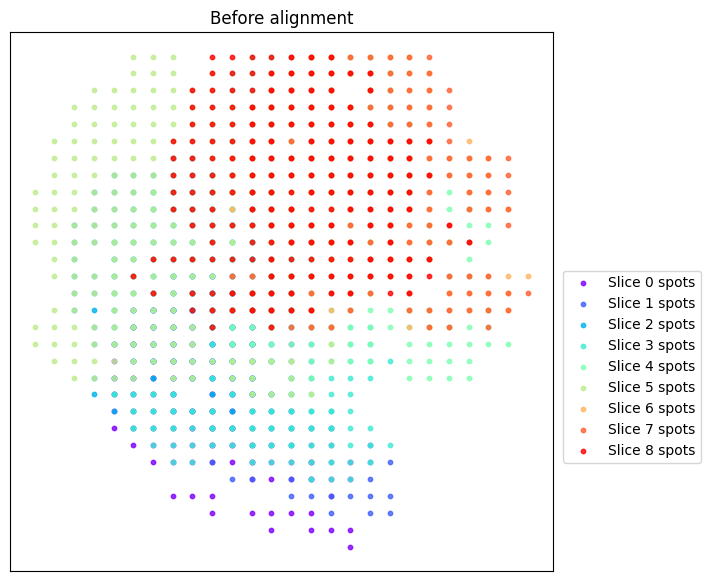

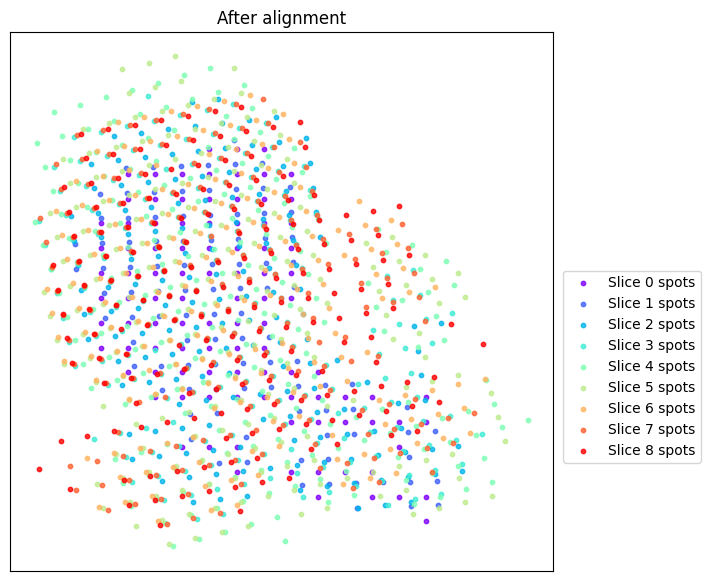

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

cmap = cm.get_cmap('rainbow', len(adata_st_list))
colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(adata_st_list))]

# Plot spots before alignment
plt.figure(figsize=(7, 7))
plt.title("Before alignment")
for i in range(len(adata_st_list)):
    plt.scatter(adata_st_list[i].obsm['loc_use'][:, 0], 
        adata_st_list[i].obsm['loc_use'][:, 1], 
        c=colors_list[i],
        label="Slice %d spots" % i, s=10, alpha=0.8)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.xticks([])
plt.yticks([])
plt.legend(loc=(1.02, .2), ncol=(len(adata_st_list)//13 + 1))
plt.show()

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

cmap = cm.get_cmap('rainbow', len(adata_st_list))
colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(adata_st_list))]

# Plot spots before alignment
plt.figure(figsize=(7, 7))
plt.title("After alignment")
for i in range(len(adata_st_list)):
    plt.scatter(adata_st_list[i].obsm['align_spatial'][:, 0], 
        adata_st_list[i].obsm['align_spatial'][:, 1], 
        c=colors_list[i],
        label="Slice %d spots" % i, s=10, alpha=0.8)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.xticks([])
plt.yticks([])
plt.legend(loc=(1.02, .2), ncol=(len(adata_st_list)//13 + 1))
plt.show()

In [10]:
# slice_use = ['Human_heart_0','Human_heart_1','Human_heart_2',
#              'Human_heart_3','Human_heart_4','Human_heart_5',
#              'Human_heart_6','Human_heart_7','Human_heart_8']
# for adata_index in range(len(adata_st_list)):
#     adata_st_list[adata_index].write("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/{}_slice.h5ad".format(slice_use[adata_index]))

In [20]:
work_path = "C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/"

slice_use = ['Human_heart_0','Human_heart_1','Human_heart_2',
            'Human_heart_3','Human_heart_4','Human_heart_5',
            'Human_heart_6','Human_heart_7','Human_heart_8']

adata_Human_heart = []

for slice in slice_use:
    file_path = work_path + str(slice) + '_slice.h5ad'
    adata = sc.read(file_path)
    adata = adata[~adata.obs['res.0.8'].isna()]
    ground_truth = np.array(adata.obs['res.0.8']).reshape(-1,1) 
    adata.obsm['ground_truth'] = ground_truth
    adata_Human_heart.append(adata)

adata_dim = []

for adata_index in range(len(adata_Human_heart)):
    adata_dim.append(adata_Human_heart[adata_index].shape[0])

adata_dim = np.cumsum(adata_dim)
adata_dim = np.insert(adata_dim,0,0)


In [ ]:
# Preprocessed data
# If the data was not processed during the alignment process, perform preliminary processing of the data
slice_matrix,adj_matrix = stVGP.adata_preprocess_adjnet(
                    input_adata = adata_Human_heart,
                    align_model = 'sequential_alignment',
                    spatial_label = 'align_spatial',
                    add_net_keywords_self = 'adj_spatial_net',
                    n_neighbors = 4,                             
                    no_cross = False)

In [ ]:
recon_x, embedding, model_params,logvar = stVGP.train_stVGP(
        ST_need_reconstruction_matrix = slice_matrix,
        all_spatial_net = adj_matrix,
        lr = 0.001,
        weight_decay = 0.0001,
        training_epoch = 1500,
        num_heads = 1,
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        save_model = False,
        save_model_path = 'path',
        hidden_embedding = [512,24],
        random_seed = 516,
        optimize_method = 'adam',
        whether_gradient_clipping = False,
        gradient_clipping = 5.0,
        all_gat = False)


Model training


100%|██████████| 1500/1500 [00:28<00:00, 53.57it/s]


In [15]:
# Save embedded layer data
# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Domain/embedding.txt',embedding,fmt='%s')

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

embedding = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Domain/embedding.txt')

for adata_index in range(len(adata_Human_heart)):
    if adata_index == 0:
        ground_truth_label = np.array(adata_Human_heart[adata_index].obsm['ground_truth'])
    else:
        ground_truth_label = np.vstack((ground_truth_label,adata_Human_heart[adata_index].obsm['ground_truth']))

cluster_num = len(np.unique(ground_truth_label))
true_labels = ground_truth_label.ravel()

np.random.seed(7)
gm = GaussianMixture(n_components=cluster_num, covariance_type='tied', init_params='kmeans')
y = gm.fit_predict(embedding, y=None)
ari = adjusted_rand_score(true_labels,y)
print(ari)

0.3940899775725549


In [18]:
AP_z = [5., 115., 85., 160., 5., 160., 5., 155.,]
AP_z = np.cumsum(AP_z)
AP_z = np.insert(AP_z,0,0)

for adata_index in range(len(adata_Human_heart)):
    if adata_index == 0:
        spatial_spots = np.array(adata_Human_heart[adata_index].obsm['align_spatial'])
        spatial_z = np.array([AP_z[adata_index]]*adata_Human_heart[adata_index].shape[0]).reshape(-1,1)
    else:
        spatial_spots = np.vstack((spatial_spots,adata_Human_heart[adata_index].obsm['align_spatial']))
        spatial_z = np.vstack((spatial_z,np.array([AP_z[adata_index]]*adata_Human_heart[adata_index].shape[0]).reshape(-1,1)))

spatial_spots = np.hstack((spatial_spots,spatial_z))

# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Domain/alignment_spatial.txt',spatial_spots,fmt='%s')
# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/admb/Domain/cluster.txt',y,fmt='%s')
# torch.save(model_params,"C:/Users/wzd/Desktop/Alignment Domain Prediction/admb/Domain/model.pth")

In [ ]:
# Gene prediction
# Masked slices prediction

spatial = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Domain/alignment_spatial.txt')
embedding = np.loadtxt("C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Domain/embedding.txt")

slice_use = ['Human_heart_0','Human_heart_1','Human_heart_2',
             'Human_heart_3','Human_heart_4','Human_heart_5',
             'Human_heart_6','Human_heart_7','Human_heart_8']

for slice_index,slice_name in enumerate(slice_use):

    Train_spatial_up = spatial[:adata_dim[slice_index]]
    Train_spatial_down = spatial[adata_dim[slice_index+1]:]

    Embedding_up = embedding[:adata_dim[slice_index]]
    Embedding_down = embedding[adata_dim[slice_index+1]:]

    Pred_spatial = spatial[adata_dim[slice_index]:adata_dim[slice_index+1]]
    Pred_embedding_true = embedding[adata_dim[slice_index]:adata_dim[slice_index+1]]

    Train_spatial = np.vstack((Train_spatial_up,Train_spatial_down))
    Train_embedding = np.vstack((Embedding_up,Embedding_down))

    pred_embedding = stVGP.get_3D_prediction(
                train_coordinates = Train_spatial,
                embedding = Train_embedding,
                spatial_pred = Pred_spatial,
                noise = False,
                noise_value = 0.00001,
                constant_value = 1.0,
                Rbf_value = 1024)
    
    print(pred_embedding.shape)

    # np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/{}_embedding.txt'.format(slice_use[slice_index]),pred_embedding,fmt='%s')

(100, 24)
(101, 24)
(155, 24)
(182, 24)
(212, 24)
(203, 24)
(173, 24)
(180, 24)
(174, 24)


In [ ]:
data_path = 'C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/'

slice_use = ['Human_heart_0','Human_heart_1','Human_heart_2',
             'Human_heart_3','Human_heart_4','Human_heart_5',
             'Human_heart_6','Human_heart_7','Human_heart_8']

adata_Human_heart = []

for slice in slice_use:
    file_path = data_path + str(slice) + '_slice.h5ad'
    adata = sc.read(file_path)
    adata = adata[~adata.obs['res.0.8'].isna()]
    ground_truth = np.array(adata.obs['res.0.8']).reshape(-1,1)
    adata.obsm['ground_truth'] = ground_truth
    adata_Human_heart.append(adata)

slice_matrix,adj_matrix = stVGP.adata_preprocess_adjnet(
                    input_adata = adata_Human_heart,
                    align_model = 'sequential_alignment',
                    spatial_label = 'align_spatial',
                    add_net_keywords_self = 'adj_spatial_net',
                    n_neighbors = 4,                             
                    no_cross = False)

slice_matrix = torch.tensor(slice_matrix, dtype=torch.float32)
edge_list = []
edge_list.append(adj_matrix.row.tolist())
edge_list.append(adj_matrix.col.tolist())
adj_tensor = torch.LongTensor(edge_list)

prediction_embedding_HH0 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_0_embedding.txt')
prediction_embedding_HH1 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_1_embedding.txt')
prediction_embedding_HH2 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_2_embedding.txt')
prediction_embedding_HH3 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_3_embedding.txt')
prediction_embedding_HH4 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_4_embedding.txt')
prediction_embedding_HH5 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_5_embedding.txt')
prediction_embedding_HH6 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_6_embedding.txt')
prediction_embedding_HH7 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_7_embedding.txt')
prediction_embedding_HH8 = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Human_heart_8_embedding.txt')

prediction_embedding = np.vstack((prediction_embedding_HH0,prediction_embedding_HH1,prediction_embedding_HH2,prediction_embedding_HH3,
                                  prediction_embedding_HH4,prediction_embedding_HH5,prediction_embedding_HH6,prediction_embedding_HH7,
                                  prediction_embedding_HH8))
prediction_embedding = torch.tensor(prediction_embedding,dtype=torch.float32)

In [23]:
model_path = 'C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Domain/' 
checkpoint = torch.load(model_path + 'model.pth')

In [ ]:
Gene_reconstruction = stVGP.gene_prediction(
    slice_matrix = slice_matrix,
    prediction_embedding = prediction_embedding,               
    adj_matrix = adj_tensor,                        
    checkpoint = checkpoint,                         
    model_layer = [slice_matrix.shape[1],512,24,1],                       
    all_gat = False,                            
    logvar = None,                            
    device = torch.device('cuda:0')
)

In [ ]:
# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/hh/Prediction and 3D/Gene_reconstruction.txt',Gene_reconstruction,fmt='%s')